##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Transfer learning and fine-tuning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb?force_kitty_mode=1&force_corgi_mode=1"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Data preprocessing

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.utils.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

    8192/68606236 [..............................] - ETA: 0s

 7479296/68606236 [==>...........................] - ETA: 0s

13877248/68606236 [=====>........................] - ETA: 0s

21946368/68606236 [========>.....................] - ETA: 0s

29425664/68606236 [===========>..................] - ETA: 0s

37273600/68606236 [===============>..............] - ETA: 0s

44933120/68606236 [==================>...........] - ETA: 0s

52903936/68606236 [======================>.......] - ETA: 0s

60424192/68606236 [=========================>....] - ETA: 0s

67911680/68606236 [============================>.] - ETA: 0s

68606236/68606236 [==============================] - 0s 0us/step


Found 2000 files belonging to 2 classes.


In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

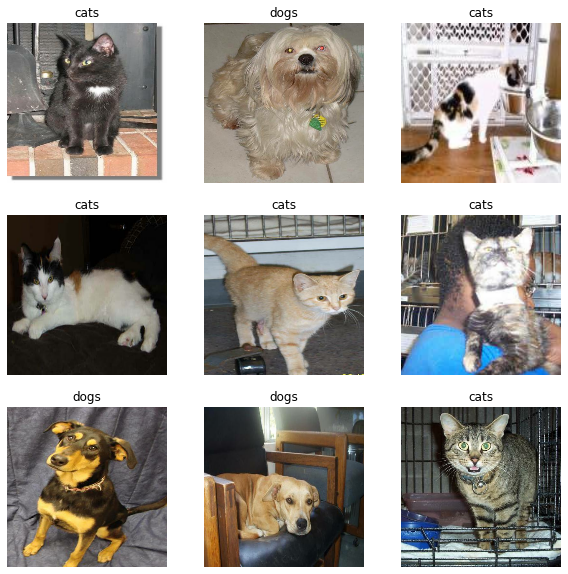

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate` or `Model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

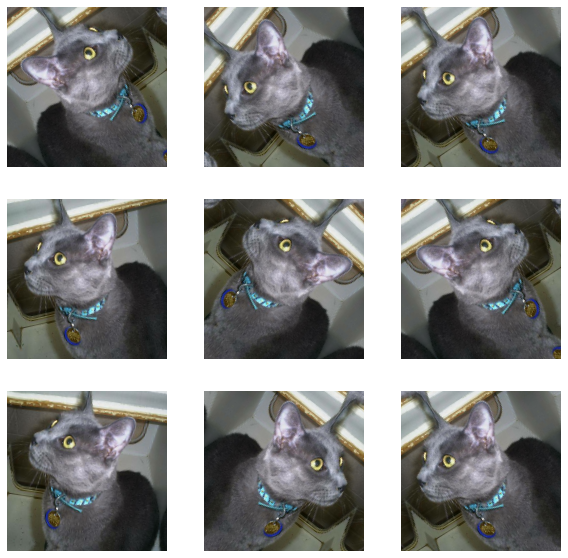

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [13]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [14]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

   8192/9406464 [..............................] - ETA: 0s

4202496/9406464 [============>.................] - ETA: 0s

9406464/9406464 [==============================] - 0s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [16]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [17]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"


__________________________________________________________________________________________________


 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               


                                )]                                                                


 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                


 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  


 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][0]']               


 expanded_conv_depthwise (Depth  (None, 80, 80, 32)  288         ['Conv1_relu[0][0]']             


 wiseConv2D)                                                                                      


 expanded_conv_depthwise_BN (Ba  (None, 80, 80, 32)  128         ['expanded_conv_depthwise[0][0]']


 tchNormalization)                                                                                


 expanded_conv_depthwise_relu (  (None, 80, 80, 32)  0           ['expanded_conv_depthwise_BN[0][0


 ReLU)                                                           ]']                              


 expanded_conv_project (Conv2D)  (None, 80, 80, 16)  512         ['expanded_conv_depthwise_relu[0]


                                                                 [0]']                            


 expanded_conv_project_BN (Batc  (None, 80, 80, 16)  64          ['expanded_conv_project[0][0]']  


 hNormalization)                                                                                  


 block_1_expand (Conv2D)        (None, 80, 80, 96)   1536        ['expanded_conv_project_BN[0][0]'


                                                                 ]                                


 block_1_expand_BN (BatchNormal  (None, 80, 80, 96)  384         ['block_1_expand[0][0]']         


 ization)                                                                                         


 block_1_expand_relu (ReLU)     (None, 80, 80, 96)   0           ['block_1_expand_BN[0][0]']      


 block_1_pad (ZeroPadding2D)    (None, 81, 81, 96)   0           ['block_1_expand_relu[0][0]']    


 block_1_depthwise (DepthwiseCo  (None, 40, 40, 96)  864         ['block_1_pad[0][0]']            


 nv2D)                                                                                            


 block_1_depthwise_BN (BatchNor  (None, 40, 40, 96)  384         ['block_1_depthwise[0][0]']      


 malization)                                                                                      


 block_1_depthwise_relu (ReLU)  (None, 40, 40, 96)   0           ['block_1_depthwise_BN[0][0]']   


 block_1_project (Conv2D)       (None, 40, 40, 24)   2304        ['block_1_depthwise_relu[0][0]'] 


 block_1_project_BN (BatchNorma  (None, 40, 40, 24)  96          ['block_1_project[0][0]']        


 lization)                                                                                        


 block_2_expand (Conv2D)        (None, 40, 40, 144)  3456        ['block_1_project_BN[0][0]']     


 block_2_expand_BN (BatchNormal  (None, 40, 40, 144)  576        ['block_2_expand[0][0]']         


 ization)                                                                                         


 block_2_expand_relu (ReLU)     (None, 40, 40, 144)  0           ['block_2_expand_BN[0][0]']      


 block_2_depthwise (DepthwiseCo  (None, 40, 40, 144)  1296       ['block_2_expand_relu[0][0]']    


 nv2D)                                                                                            


 block_2_depthwise_BN (BatchNor  (None, 40, 40, 144)  576        ['block_2_depthwise[0][0]']      


 malization)                                                                                      


 block_2_depthwise_relu (ReLU)  (None, 40, 40, 144)  0           ['block_2_depthwise_BN[0][0]']   


 block_2_project (Conv2D)       (None, 40, 40, 24)   3456        ['block_2_depthwise_relu[0][0]'] 


 block_2_project_BN (BatchNorma  (None, 40, 40, 24)  96          ['block_2_project[0][0]']        


 lization)                                                                                        


 block_2_add (Add)              (None, 40, 40, 24)   0           ['block_1_project_BN[0][0]',     


                                                                  'block_2_project_BN[0][0]']     


 block_3_expand (Conv2D)        (None, 40, 40, 144)  3456        ['block_2_add[0][0]']            


 block_3_expand_BN (BatchNormal  (None, 40, 40, 144)  576        ['block_3_expand[0][0]']         


 ization)                                                                                         


 block_3_expand_relu (ReLU)     (None, 40, 40, 144)  0           ['block_3_expand_BN[0][0]']      


 block_3_pad (ZeroPadding2D)    (None, 41, 41, 144)  0           ['block_3_expand_relu[0][0]']    


 block_3_depthwise (DepthwiseCo  (None, 20, 20, 144)  1296       ['block_3_pad[0][0]']            


 nv2D)                                                                                            


 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      


 malization)                                                                                      


 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   


 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 


 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        


 lization)                                                                                        


 block_4_expand (Conv2D)        (None, 20, 20, 192)  6144        ['block_3_project_BN[0][0]']     


 block_4_expand_BN (BatchNormal  (None, 20, 20, 192)  768        ['block_4_expand[0][0]']         


 ization)                                                                                         


 block_4_expand_relu (ReLU)     (None, 20, 20, 192)  0           ['block_4_expand_BN[0][0]']      


 block_4_depthwise (DepthwiseCo  (None, 20, 20, 192)  1728       ['block_4_expand_relu[0][0]']    


 nv2D)                                                                                            


 block_4_depthwise_BN (BatchNor  (None, 20, 20, 192)  768        ['block_4_depthwise[0][0]']      


 malization)                                                                                      


 block_4_depthwise_relu (ReLU)  (None, 20, 20, 192)  0           ['block_4_depthwise_BN[0][0]']   


 block_4_project (Conv2D)       (None, 20, 20, 32)   6144        ['block_4_depthwise_relu[0][0]'] 


 block_4_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_4_project[0][0]']        


 lization)                                                                                        


 block_4_add (Add)              (None, 20, 20, 32)   0           ['block_3_project_BN[0][0]',     


                                                                  'block_4_project_BN[0][0]']     


 block_5_expand (Conv2D)        (None, 20, 20, 192)  6144        ['block_4_add[0][0]']            


 block_5_expand_BN (BatchNormal  (None, 20, 20, 192)  768        ['block_5_expand[0][0]']         


 ization)                                                                                         


 block_5_expand_relu (ReLU)     (None, 20, 20, 192)  0           ['block_5_expand_BN[0][0]']      


 block_5_depthwise (DepthwiseCo  (None, 20, 20, 192)  1728       ['block_5_expand_relu[0][0]']    


 nv2D)                                                                                            


 block_5_depthwise_BN (BatchNor  (None, 20, 20, 192)  768        ['block_5_depthwise[0][0]']      


 malization)                                                                                      


 block_5_depthwise_relu (ReLU)  (None, 20, 20, 192)  0           ['block_5_depthwise_BN[0][0]']   


 block_5_project (Conv2D)       (None, 20, 20, 32)   6144        ['block_5_depthwise_relu[0][0]'] 


 block_5_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_5_project[0][0]']        


 lization)                                                                                        


 block_5_add (Add)              (None, 20, 20, 32)   0           ['block_4_add[0][0]',            


                                                                  'block_5_project_BN[0][0]']     


 block_6_expand (Conv2D)        (None, 20, 20, 192)  6144        ['block_5_add[0][0]']            


 block_6_expand_BN (BatchNormal  (None, 20, 20, 192)  768        ['block_6_expand[0][0]']         


 ization)                                                                                         


 block_6_expand_relu (ReLU)     (None, 20, 20, 192)  0           ['block_6_expand_BN[0][0]']      


 block_6_pad (ZeroPadding2D)    (None, 21, 21, 192)  0           ['block_6_expand_relu[0][0]']    


 block_6_depthwise (DepthwiseCo  (None, 10, 10, 192)  1728       ['block_6_pad[0][0]']            


 nv2D)                                                                                            


 block_6_depthwise_BN (BatchNor  (None, 10, 10, 192)  768        ['block_6_depthwise[0][0]']      


 malization)                                                                                      


 block_6_depthwise_relu (ReLU)  (None, 10, 10, 192)  0           ['block_6_depthwise_BN[0][0]']   


 block_6_project (Conv2D)       (None, 10, 10, 64)   12288       ['block_6_depthwise_relu[0][0]'] 


 block_6_project_BN (BatchNorma  (None, 10, 10, 64)  256         ['block_6_project[0][0]']        


 lization)                                                                                        


 block_7_expand (Conv2D)        (None, 10, 10, 384)  24576       ['block_6_project_BN[0][0]']     


 block_7_expand_BN (BatchNormal  (None, 10, 10, 384)  1536       ['block_7_expand[0][0]']         


 ization)                                                                                         


 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      


 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    


 nv2D)                                                                                            


 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      


 malization)                                                                                      


 block_7_depthwise_relu (ReLU)  (None, 10, 10, 384)  0           ['block_7_depthwise_BN[0][0]']   


 block_7_project (Conv2D)       (None, 10, 10, 64)   24576       ['block_7_depthwise_relu[0][0]'] 


 block_7_project_BN (BatchNorma  (None, 10, 10, 64)  256         ['block_7_project[0][0]']        


 lization)                                                                                        


 block_7_add (Add)              (None, 10, 10, 64)   0           ['block_6_project_BN[0][0]',     


                                                                  'block_7_project_BN[0][0]']     


 block_8_expand (Conv2D)        (None, 10, 10, 384)  24576       ['block_7_add[0][0]']            


 block_8_expand_BN (BatchNormal  (None, 10, 10, 384)  1536       ['block_8_expand[0][0]']         


 ization)                                                                                         


 block_8_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_8_expand_BN[0][0]']      


 block_8_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_8_expand_relu[0][0]']    


 nv2D)                                                                                            


 block_8_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_8_depthwise[0][0]']      


 malization)                                                                                      


 block_8_depthwise_relu (ReLU)  (None, 10, 10, 384)  0           ['block_8_depthwise_BN[0][0]']   


 block_8_project (Conv2D)       (None, 10, 10, 64)   24576       ['block_8_depthwise_relu[0][0]'] 


 block_8_project_BN (BatchNorma  (None, 10, 10, 64)  256         ['block_8_project[0][0]']        


 lization)                                                                                        


 block_8_add (Add)              (None, 10, 10, 64)   0           ['block_7_add[0][0]',            


                                                                  'block_8_project_BN[0][0]']     


 block_9_expand (Conv2D)        (None, 10, 10, 384)  24576       ['block_8_add[0][0]']            


 block_9_expand_BN (BatchNormal  (None, 10, 10, 384)  1536       ['block_9_expand[0][0]']         


 ization)                                                                                         


 block_9_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_9_expand_BN[0][0]']      


 block_9_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_9_expand_relu[0][0]']    


 nv2D)                                                                                            


 block_9_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_9_depthwise[0][0]']      


 malization)                                                                                      


 block_9_depthwise_relu (ReLU)  (None, 10, 10, 384)  0           ['block_9_depthwise_BN[0][0]']   


 block_9_project (Conv2D)       (None, 10, 10, 64)   24576       ['block_9_depthwise_relu[0][0]'] 


 block_9_project_BN (BatchNorma  (None, 10, 10, 64)  256         ['block_9_project[0][0]']        


 lization)                                                                                        


 block_9_add (Add)              (None, 10, 10, 64)   0           ['block_8_add[0][0]',            


                                                                  'block_9_project_BN[0][0]']     


 block_10_expand (Conv2D)       (None, 10, 10, 384)  24576       ['block_9_add[0][0]']            


 block_10_expand_BN (BatchNorma  (None, 10, 10, 384)  1536       ['block_10_expand[0][0]']        


 lization)                                                                                        


 block_10_expand_relu (ReLU)    (None, 10, 10, 384)  0           ['block_10_expand_BN[0][0]']     


 block_10_depthwise (DepthwiseC  (None, 10, 10, 384)  3456       ['block_10_expand_relu[0][0]']   


 onv2D)                                                                                           


 block_10_depthwise_BN (BatchNo  (None, 10, 10, 384)  1536       ['block_10_depthwise[0][0]']     


 rmalization)                                                                                     


 block_10_depthwise_relu (ReLU)  (None, 10, 10, 384)  0          ['block_10_depthwise_BN[0][0]']  


 block_10_project (Conv2D)      (None, 10, 10, 96)   36864       ['block_10_depthwise_relu[0][0]']


 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       


 alization)                                                                                       


 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    


 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        


 lization)                                                                                        


 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     


 block_11_depthwise (DepthwiseC  (None, 10, 10, 576)  5184       ['block_11_expand_relu[0][0]']   


 onv2D)                                                                                           


 block_11_depthwise_BN (BatchNo  (None, 10, 10, 576)  2304       ['block_11_depthwise[0][0]']     


 rmalization)                                                                                     


 block_11_depthwise_relu (ReLU)  (None, 10, 10, 576)  0          ['block_11_depthwise_BN[0][0]']  


 block_11_project (Conv2D)      (None, 10, 10, 96)   55296       ['block_11_depthwise_relu[0][0]']


 block_11_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_11_project[0][0]']       


 alization)                                                                                       


 block_11_add (Add)             (None, 10, 10, 96)   0           ['block_10_project_BN[0][0]',    


                                                                  'block_11_project_BN[0][0]']    


 block_12_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_11_add[0][0]']           


 block_12_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_12_expand[0][0]']        


 lization)                                                                                        


 block_12_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_12_expand_BN[0][0]']     


 block_12_depthwise (DepthwiseC  (None, 10, 10, 576)  5184       ['block_12_expand_relu[0][0]']   


 onv2D)                                                                                           


 block_12_depthwise_BN (BatchNo  (None, 10, 10, 576)  2304       ['block_12_depthwise[0][0]']     


 rmalization)                                                                                     


 block_12_depthwise_relu (ReLU)  (None, 10, 10, 576)  0          ['block_12_depthwise_BN[0][0]']  


 block_12_project (Conv2D)      (None, 10, 10, 96)   55296       ['block_12_depthwise_relu[0][0]']


 block_12_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_12_project[0][0]']       


 alization)                                                                                       


 block_12_add (Add)             (None, 10, 10, 96)   0           ['block_11_add[0][0]',           


                                                                  'block_12_project_BN[0][0]']    


 block_13_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_12_add[0][0]']           


 block_13_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_13_expand[0][0]']        


 lization)                                                                                        


 block_13_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_13_expand_BN[0][0]']     


 block_13_pad (ZeroPadding2D)   (None, 11, 11, 576)  0           ['block_13_expand_relu[0][0]']   


 block_13_depthwise (DepthwiseC  (None, 5, 5, 576)   5184        ['block_13_pad[0][0]']           


 onv2D)                                                                                           


 block_13_depthwise_BN (BatchNo  (None, 5, 5, 576)   2304        ['block_13_depthwise[0][0]']     


 rmalization)                                                                                     


 block_13_depthwise_relu (ReLU)  (None, 5, 5, 576)   0           ['block_13_depthwise_BN[0][0]']  


 block_13_project (Conv2D)      (None, 5, 5, 160)    92160       ['block_13_depthwise_relu[0][0]']


 block_13_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_13_project[0][0]']       


 alization)                                                                                       


 block_14_expand (Conv2D)       (None, 5, 5, 960)    153600      ['block_13_project_BN[0][0]']    


 block_14_expand_BN (BatchNorma  (None, 5, 5, 960)   3840        ['block_14_expand[0][0]']        


 lization)                                                                                        


 block_14_expand_relu (ReLU)    (None, 5, 5, 960)    0           ['block_14_expand_BN[0][0]']     


 block_14_depthwise (DepthwiseC  (None, 5, 5, 960)   8640        ['block_14_expand_relu[0][0]']   


 onv2D)                                                                                           


 block_14_depthwise_BN (BatchNo  (None, 5, 5, 960)   3840        ['block_14_depthwise[0][0]']     


 rmalization)                                                                                     


 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  


 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']


 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       


 alization)                                                                                       


 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    


                                                                  'block_14_project_BN[0][0]']    


 block_15_expand (Conv2D)       (None, 5, 5, 960)    153600      ['block_14_add[0][0]']           


 block_15_expand_BN (BatchNorma  (None, 5, 5, 960)   3840        ['block_15_expand[0][0]']        


 lization)                                                                                        


 block_15_expand_relu (ReLU)    (None, 5, 5, 960)    0           ['block_15_expand_BN[0][0]']     


 block_15_depthwise (DepthwiseC  (None, 5, 5, 960)   8640        ['block_15_expand_relu[0][0]']   


 onv2D)                                                                                           


 block_15_depthwise_BN (BatchNo  (None, 5, 5, 960)   3840        ['block_15_depthwise[0][0]']     


 rmalization)                                                                                     


 block_15_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_15_depthwise_BN[0][0]']  


 block_15_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_15_depthwise_relu[0][0]']


 block_15_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_15_project[0][0]']       


 alization)                                                                                       


 block_15_add (Add)             (None, 5, 5, 160)    0           ['block_14_add[0][0]',           


                                                                  'block_15_project_BN[0][0]']    


 block_16_expand (Conv2D)       (None, 5, 5, 960)    153600      ['block_15_add[0][0]']           


 block_16_expand_BN (BatchNorma  (None, 5, 5, 960)   3840        ['block_16_expand[0][0]']        


 lization)                                                                                        


 block_16_expand_relu (ReLU)    (None, 5, 5, 960)    0           ['block_16_expand_BN[0][0]']     


 block_16_depthwise (DepthwiseC  (None, 5, 5, 960)   8640        ['block_16_expand_relu[0][0]']   


 onv2D)                                                                                           


 block_16_depthwise_BN (BatchNo  (None, 5, 5, 960)   3840        ['block_16_depthwise[0][0]']     


 rmalization)                                                                                     


 block_16_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_16_depthwise_BN[0][0]']  


 block_16_project (Conv2D)      (None, 5, 5, 320)    307200      ['block_16_depthwise_relu[0][0]']


 block_16_project_BN (BatchNorm  (None, 5, 5, 320)   1280        ['block_16_project[0][0]']       


 alization)                                                                                       


 Conv_1 (Conv2D)                (None, 5, 5, 1280)   409600      ['block_16_project_BN[0][0]']    


 Conv_1_bn (BatchNormalization)  (None, 5, 5, 1280)  5120        ['Conv_1[0][0]']                 


 out_relu (ReLU)                (None, 5, 5, 1280)   0           ['Conv_1_bn[0][0]']              


Total params: 2,257,984


Trainable params: 0


Non-trainable params: 2,257,984


__________________________________________________________________________________________________


### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [19]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [20]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         


 sequential (Sequential)     (None, 160, 160, 3)       0         


 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         


 )                                                               


 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         


 a)                                                              


 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   


 ional)                                                          


 global_average_pooling2d (G  (None, 1280)             0         


 lobalAveragePooling2D)                                          


 dropout (Dropout)           (None, 1280)              0         


 dense (Dense)               (None, 1)                 1281      


Total params: 2,259,265


Trainable params: 1,281


Non-trainable params: 2,257,984


_________________________________________________________________


The 2.5 million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [23]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [24]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

 1/26 [>.............................] - ETA: 32s - loss: 0.8032 - accuracy: 0.4688

 4/26 [===>..........................] - ETA: 0s - loss: 0.8377 - accuracy: 0.4453 

 7/26 [=======>......................] - ETA: 0s - loss: 0.8395 - accuracy: 0.4598

10/26 [==========>...................] - ETA: 0s - loss: 0.8248 - accuracy: 0.4625

13/26 [==============>...............] - ETA: 0s - loss: 0.8257 - accuracy: 0.4760

16/26 [=================>............] - ETA: 0s - loss: 0.8152 - accuracy: 0.4844

19/26 [====================>.........] - ETA: 0s - loss: 0.8223 - accuracy: 0.4803

22/26 [========================>.....] - ETA: 0s - loss: 0.8375 - accuracy: 0.4744

26/26 [==============================] - ETA: 0s - loss: 0.8350 - accuracy: 0.4802

26/26 [==============================] - 2s 20ms/step - loss: 0.8350 - accuracy: 0.4802


In [25]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.83
initial accuracy: 0.48


In [26]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


 1/63 [..............................] - ETA: 2:36 - loss: 0.9221 - accuracy: 0.4375

 3/63 [>.............................] - ETA: 1s - loss: 0.9257 - accuracy: 0.4375  

 5/63 [=>............................] - ETA: 1s - loss: 0.9143 - accuracy: 0.4437

 7/63 [==>...........................] - ETA: 1s - loss: 0.8891 - accuracy: 0.4643

 9/63 [===>..........................] - ETA: 1s - loss: 0.8917 - accuracy: 0.4618

11/63 [====>.........................] - ETA: 1s - loss: 0.8820 - accuracy: 0.4744

13/63 [=====>........................] - ETA: 1s - loss: 0.8773 - accuracy: 0.4712

15/63 [======>.......................] - ETA: 1s - loss: 0.8791 - accuracy: 0.4667

17/63 [=======>......................] - ETA: 1s - loss: 0.8674 - accuracy: 0.4779

19/63 [========>.....................] - ETA: 1s - loss: 0.8602 - accuracy: 0.4786

21/63 [=========>....................] - ETA: 1s - loss: 0.8539 - accuracy: 0.4940

23/63 [=========>....................] - ETA: 1s - loss: 0.8539 - accuracy: 0.4932

25/63 [==========>...................] - ETA: 1s - loss: 0.8612 - accuracy: 0.4888

27/63 [===========>..................] - ETA: 1s - loss: 0.8444 - accuracy: 0.4954

29/63 [============>.................] - ETA: 0s - loss: 0.8350 - accuracy: 0.4978

31/63 [=============>................] - ETA: 0s - loss: 0.8340 - accuracy: 0.5010

33/63 [==============>...............] - ETA: 0s - loss: 0.8231 - accuracy: 0.5066

35/63 [===============>..............] - ETA: 0s - loss: 0.8210 - accuracy: 0.5054

37/63 [================>.............] - ETA: 0s - loss: 0.8163 - accuracy: 0.5084

39/63 [=================>............] - ETA: 0s - loss: 0.8099 - accuracy: 0.5112

41/63 [==================>...........] - ETA: 0s - loss: 0.8038 - accuracy: 0.5130

43/63 [===================>..........] - ETA: 0s - loss: 0.7985 - accuracy: 0.5145

45/63 [====================>.........] - ETA: 0s - loss: 0.7986 - accuracy: 0.5132

47/63 [=====================>........] - ETA: 0s - loss: 0.7938 - accuracy: 0.5186

49/63 [======================>.......] - ETA: 0s - loss: 0.7915 - accuracy: 0.5198

51/63 [=======================>......] - ETA: 0s - loss: 0.7868 - accuracy: 0.5257

53/63 [========================>.....] - ETA: 0s - loss: 0.7841 - accuracy: 0.5277

55/63 [=========================>....] - ETA: 0s - loss: 0.7795 - accuracy: 0.5290

57/63 [==========================>...] - ETA: 0s - loss: 0.7765 - accuracy: 0.5312

59/63 [===========================>..] - ETA: 0s - loss: 0.7713 - accuracy: 0.5355

61/63 [============================>.] - ETA: 0s - loss: 0.7672 - accuracy: 0.5389

63/63 [==============================] - ETA: 0s - loss: 0.7652 - accuracy: 0.5425

63/63 [==============================] - 5s 37ms/step - loss: 0.7652 - accuracy: 0.5425 - val_loss: 0.5543 - val_accuracy: 0.6696


Epoch 2/10


 1/63 [..............................] - ETA: 3s - loss: 0.5888 - accuracy: 0.4688

 3/63 [>.............................] - ETA: 1s - loss: 0.7088 - accuracy: 0.5104

 5/63 [=>............................] - ETA: 1s - loss: 0.6363 - accuracy: 0.5938

 7/63 [==>...........................] - ETA: 1s - loss: 0.6431 - accuracy: 0.5938

 9/63 [===>..........................] - ETA: 1s - loss: 0.6364 - accuracy: 0.6042

11/63 [====>.........................] - ETA: 1s - loss: 0.6324 - accuracy: 0.6165

13/63 [=====>........................] - ETA: 1s - loss: 0.6411 - accuracy: 0.6058

15/63 [======>.......................] - ETA: 1s - loss: 0.6413 - accuracy: 0.5958

17/63 [=======>......................] - ETA: 1s - loss: 0.6301 - accuracy: 0.6011

19/63 [========>.....................] - ETA: 1s - loss: 0.6295 - accuracy: 0.6053

21/63 [=========>....................] - ETA: 1s - loss: 0.6184 - accuracy: 0.6116

23/63 [=========>....................] - ETA: 1s - loss: 0.6114 - accuracy: 0.6168

25/63 [==========>...................] - ETA: 1s - loss: 0.6091 - accuracy: 0.6212

27/63 [===========>..................] - ETA: 1s - loss: 0.5984 - accuracy: 0.6262

29/63 [============>.................] - ETA: 0s - loss: 0.5960 - accuracy: 0.6282

31/63 [=============>................] - ETA: 0s - loss: 0.5913 - accuracy: 0.6331

33/63 [==============>...............] - ETA: 0s - loss: 0.5898 - accuracy: 0.6354

35/63 [===============>..............] - ETA: 0s - loss: 0.5845 - accuracy: 0.6402

37/63 [================>.............] - ETA: 0s - loss: 0.5828 - accuracy: 0.6444

39/63 [=================>............] - ETA: 0s - loss: 0.5773 - accuracy: 0.6514

41/63 [==================>...........] - ETA: 0s - loss: 0.5774 - accuracy: 0.6509

43/63 [===================>..........] - ETA: 0s - loss: 0.5743 - accuracy: 0.6533

45/63 [====================>.........] - ETA: 0s - loss: 0.5745 - accuracy: 0.6542

47/63 [=====================>........] - ETA: 0s - loss: 0.5726 - accuracy: 0.6576

49/63 [======================>.......] - ETA: 0s - loss: 0.5717 - accuracy: 0.6582

51/63 [=======================>......] - ETA: 0s - loss: 0.5715 - accuracy: 0.6593

53/63 [========================>.....] - ETA: 0s - loss: 0.5701 - accuracy: 0.6598

55/63 [=========================>....] - ETA: 0s - loss: 0.5648 - accuracy: 0.6670

57/63 [==========================>...] - ETA: 0s - loss: 0.5643 - accuracy: 0.6667

59/63 [===========================>..] - ETA: 0s - loss: 0.5607 - accuracy: 0.6700

61/63 [============================>.] - ETA: 0s - loss: 0.5615 - accuracy: 0.6706

63/63 [==============================] - 2s 35ms/step - loss: 0.5610 - accuracy: 0.6695 - val_loss: 0.4037 - val_accuracy: 0.7847


Epoch 3/10


 1/63 [..............................] - ETA: 3s - loss: 0.4030 - accuracy: 0.7812

 3/63 [>.............................] - ETA: 1s - loss: 0.4507 - accuracy: 0.7188

 5/63 [=>............................] - ETA: 1s - loss: 0.4649 - accuracy: 0.7125

 7/63 [==>...........................] - ETA: 1s - loss: 0.4779 - accuracy: 0.7277

 9/63 [===>..........................] - ETA: 1s - loss: 0.4856 - accuracy: 0.7222

11/63 [====>.........................] - ETA: 1s - loss: 0.4841 - accuracy: 0.7358

13/63 [=====>........................] - ETA: 1s - loss: 0.4876 - accuracy: 0.7332

15/63 [======>.......................] - ETA: 1s - loss: 0.4782 - accuracy: 0.7437

17/63 [=======>......................] - ETA: 1s - loss: 0.4798 - accuracy: 0.7445

19/63 [========>.....................] - ETA: 1s - loss: 0.4718 - accuracy: 0.7418

21/63 [=========>....................] - ETA: 1s - loss: 0.4681 - accuracy: 0.7470

23/63 [=========>....................] - ETA: 1s - loss: 0.4638 - accuracy: 0.7582

25/63 [==========>...................] - ETA: 1s - loss: 0.4587 - accuracy: 0.7625

27/63 [===========>..................] - ETA: 1s - loss: 0.4571 - accuracy: 0.7627

29/63 [============>.................] - ETA: 0s - loss: 0.4490 - accuracy: 0.7705

31/63 [=============>................] - ETA: 0s - loss: 0.4483 - accuracy: 0.7702

33/63 [==============>...............] - ETA: 0s - loss: 0.4490 - accuracy: 0.7699

35/63 [===============>..............] - ETA: 0s - loss: 0.4527 - accuracy: 0.7688

37/63 [================>.............] - ETA: 0s - loss: 0.4491 - accuracy: 0.7720

39/63 [=================>............] - ETA: 0s - loss: 0.4507 - accuracy: 0.7708

41/63 [==================>...........] - ETA: 0s - loss: 0.4463 - accuracy: 0.7736

43/63 [===================>..........] - ETA: 0s - loss: 0.4456 - accuracy: 0.7740

45/63 [====================>.........] - ETA: 0s - loss: 0.4443 - accuracy: 0.7736

47/63 [=====================>........] - ETA: 0s - loss: 0.4438 - accuracy: 0.7753

49/63 [======================>.......] - ETA: 0s - loss: 0.4421 - accuracy: 0.7774

51/63 [=======================>......] - ETA: 0s - loss: 0.4393 - accuracy: 0.7794

53/63 [========================>.....] - ETA: 0s - loss: 0.4406 - accuracy: 0.7771

55/63 [=========================>....] - ETA: 0s - loss: 0.4396 - accuracy: 0.7767

57/63 [==========================>...] - ETA: 0s - loss: 0.4375 - accuracy: 0.7769

59/63 [===========================>..] - ETA: 0s - loss: 0.4373 - accuracy: 0.7765

61/63 [============================>.] - ETA: 0s - loss: 0.4370 - accuracy: 0.7761

63/63 [==============================] - 2s 36ms/step - loss: 0.4363 - accuracy: 0.7770 - val_loss: 0.3068 - val_accuracy: 0.8428


Epoch 4/10


 1/63 [..............................] - ETA: 3s - loss: 0.5557 - accuracy: 0.6250

 3/63 [>.............................] - ETA: 1s - loss: 0.4583 - accuracy: 0.7292

 5/63 [=>............................] - ETA: 1s - loss: 0.4438 - accuracy: 0.7500

 7/63 [==>...........................] - ETA: 1s - loss: 0.4140 - accuracy: 0.7768

 9/63 [===>..........................] - ETA: 1s - loss: 0.4041 - accuracy: 0.7882

11/63 [====>.........................] - ETA: 1s - loss: 0.4157 - accuracy: 0.7784

13/63 [=====>........................] - ETA: 1s - loss: 0.4054 - accuracy: 0.7909

15/63 [======>.......................] - ETA: 1s - loss: 0.3915 - accuracy: 0.7979

17/63 [=======>......................] - ETA: 1s - loss: 0.3855 - accuracy: 0.8033

19/63 [========>.....................] - ETA: 1s - loss: 0.3773 - accuracy: 0.8092

21/63 [=========>....................] - ETA: 1s - loss: 0.3736 - accuracy: 0.8140

23/63 [=========>....................] - ETA: 1s - loss: 0.3811 - accuracy: 0.8125

25/63 [==========>...................] - ETA: 1s - loss: 0.3799 - accuracy: 0.8087

27/63 [===========>..................] - ETA: 1s - loss: 0.3789 - accuracy: 0.8067

29/63 [============>.................] - ETA: 0s - loss: 0.3785 - accuracy: 0.8060

31/63 [=============>................] - ETA: 0s - loss: 0.3844 - accuracy: 0.8014

33/63 [==============>...............] - ETA: 0s - loss: 0.3776 - accuracy: 0.8068

35/63 [===============>..............] - ETA: 0s - loss: 0.3797 - accuracy: 0.8062

37/63 [================>.............] - ETA: 0s - loss: 0.3825 - accuracy: 0.8049

39/63 [=================>............] - ETA: 0s - loss: 0.3833 - accuracy: 0.8061

41/63 [==================>...........] - ETA: 0s - loss: 0.3852 - accuracy: 0.8064

43/63 [===================>..........] - ETA: 0s - loss: 0.3812 - accuracy: 0.8103

45/63 [====================>.........] - ETA: 0s - loss: 0.3810 - accuracy: 0.8132

47/63 [=====================>........] - ETA: 0s - loss: 0.3831 - accuracy: 0.8105

49/63 [======================>.......] - ETA: 0s - loss: 0.3806 - accuracy: 0.8119

51/63 [=======================>......] - ETA: 0s - loss: 0.3771 - accuracy: 0.8143

53/63 [========================>.....] - ETA: 0s - loss: 0.3759 - accuracy: 0.8154

55/63 [=========================>....] - ETA: 0s - loss: 0.3741 - accuracy: 0.8182

57/63 [==========================>...] - ETA: 0s - loss: 0.3716 - accuracy: 0.8185

59/63 [===========================>..] - ETA: 0s - loss: 0.3697 - accuracy: 0.8194

61/63 [============================>.] - ETA: 0s - loss: 0.3692 - accuracy: 0.8186

63/63 [==============================] - 2s 35ms/step - loss: 0.3677 - accuracy: 0.8195 - val_loss: 0.2520 - val_accuracy: 0.8886


Epoch 5/10


 1/63 [..............................] - ETA: 3s - loss: 0.3130 - accuracy: 0.8438

 3/63 [>.............................] - ETA: 1s - loss: 0.3430 - accuracy: 0.8229

 5/63 [=>............................] - ETA: 1s - loss: 0.3183 - accuracy: 0.8562

 7/63 [==>...........................] - ETA: 1s - loss: 0.3321 - accuracy: 0.8482

 9/63 [===>..........................] - ETA: 1s - loss: 0.3500 - accuracy: 0.8403

11/63 [====>.........................] - ETA: 1s - loss: 0.3510 - accuracy: 0.8352

13/63 [=====>........................] - ETA: 1s - loss: 0.3463 - accuracy: 0.8438

15/63 [======>.......................] - ETA: 1s - loss: 0.3326 - accuracy: 0.8562

17/63 [=======>......................] - ETA: 1s - loss: 0.3276 - accuracy: 0.8603

19/63 [========>.....................] - ETA: 1s - loss: 0.3256 - accuracy: 0.8503

21/63 [=========>....................] - ETA: 1s - loss: 0.3280 - accuracy: 0.8512

23/63 [=========>....................] - ETA: 1s - loss: 0.3225 - accuracy: 0.8519

25/63 [==========>...................] - ETA: 1s - loss: 0.3174 - accuracy: 0.8550

27/63 [===========>..................] - ETA: 1s - loss: 0.3190 - accuracy: 0.8530

29/63 [============>.................] - ETA: 0s - loss: 0.3152 - accuracy: 0.8545

31/63 [=============>................] - ETA: 0s - loss: 0.3142 - accuracy: 0.8548

33/63 [==============>...............] - ETA: 0s - loss: 0.3142 - accuracy: 0.8551

35/63 [===============>..............] - ETA: 0s - loss: 0.3149 - accuracy: 0.8562

37/63 [================>.............] - ETA: 0s - loss: 0.3136 - accuracy: 0.8581

39/63 [=================>............] - ETA: 0s - loss: 0.3143 - accuracy: 0.8566

41/63 [==================>...........] - ETA: 0s - loss: 0.3139 - accuracy: 0.8590

43/63 [===================>..........] - ETA: 0s - loss: 0.3140 - accuracy: 0.8619

45/63 [====================>.........] - ETA: 0s - loss: 0.3143 - accuracy: 0.8632

47/63 [=====================>........] - ETA: 0s - loss: 0.3181 - accuracy: 0.8624

49/63 [======================>.......] - ETA: 0s - loss: 0.3193 - accuracy: 0.8603

51/63 [=======================>......] - ETA: 0s - loss: 0.3194 - accuracy: 0.8597

53/63 [========================>.....] - ETA: 0s - loss: 0.3197 - accuracy: 0.8585

55/63 [=========================>....] - ETA: 0s - loss: 0.3202 - accuracy: 0.8574

57/63 [==========================>...] - ETA: 0s - loss: 0.3213 - accuracy: 0.8564

59/63 [===========================>..] - ETA: 0s - loss: 0.3198 - accuracy: 0.8570

61/63 [============================>.] - ETA: 0s - loss: 0.3181 - accuracy: 0.8591

63/63 [==============================] - 2s 35ms/step - loss: 0.3183 - accuracy: 0.8595 - val_loss: 0.2180 - val_accuracy: 0.8985


Epoch 6/10


 1/63 [..............................] - ETA: 3s - loss: 0.3548 - accuracy: 0.7500

 3/63 [>.............................] - ETA: 1s - loss: 0.2926 - accuracy: 0.8438

 5/63 [=>............................] - ETA: 1s - loss: 0.3272 - accuracy: 0.8125

 7/63 [==>...........................] - ETA: 1s - loss: 0.3239 - accuracy: 0.8170

 9/63 [===>..........................] - ETA: 1s - loss: 0.3029 - accuracy: 0.8333

11/63 [====>.........................] - ETA: 1s - loss: 0.3062 - accuracy: 0.8324

13/63 [=====>........................] - ETA: 1s - loss: 0.3070 - accuracy: 0.8365

15/63 [======>.......................] - ETA: 1s - loss: 0.3079 - accuracy: 0.8438

17/63 [=======>......................] - ETA: 1s - loss: 0.3066 - accuracy: 0.8456

19/63 [========>.....................] - ETA: 1s - loss: 0.3050 - accuracy: 0.8454

21/63 [=========>....................] - ETA: 1s - loss: 0.3009 - accuracy: 0.8512

23/63 [=========>....................] - ETA: 1s - loss: 0.3058 - accuracy: 0.8519

25/63 [==========>...................] - ETA: 1s - loss: 0.3070 - accuracy: 0.8512

27/63 [===========>..................] - ETA: 1s - loss: 0.3022 - accuracy: 0.8530

29/63 [============>.................] - ETA: 0s - loss: 0.2987 - accuracy: 0.8556

31/63 [=============>................] - ETA: 0s - loss: 0.2973 - accuracy: 0.8569

33/63 [==============>...............] - ETA: 0s - loss: 0.2969 - accuracy: 0.8532

35/63 [===============>..............] - ETA: 0s - loss: 0.3014 - accuracy: 0.8518

37/63 [================>.............] - ETA: 0s - loss: 0.3048 - accuracy: 0.8497

39/63 [=================>............] - ETA: 0s - loss: 0.3020 - accuracy: 0.8534

41/63 [==================>...........] - ETA: 0s - loss: 0.3032 - accuracy: 0.8537

43/63 [===================>..........] - ETA: 0s - loss: 0.3038 - accuracy: 0.8554

45/63 [====================>.........] - ETA: 0s - loss: 0.3037 - accuracy: 0.8569

47/63 [=====================>........] - ETA: 0s - loss: 0.3052 - accuracy: 0.8557

49/63 [======================>.......] - ETA: 0s - loss: 0.3014 - accuracy: 0.8578

51/63 [=======================>......] - ETA: 0s - loss: 0.3031 - accuracy: 0.8572

53/63 [========================>.....] - ETA: 0s - loss: 0.3003 - accuracy: 0.8603

55/63 [=========================>....] - ETA: 0s - loss: 0.3002 - accuracy: 0.8602

57/63 [==========================>...] - ETA: 0s - loss: 0.2989 - accuracy: 0.8624

59/63 [===========================>..] - ETA: 0s - loss: 0.2969 - accuracy: 0.8628

61/63 [============================>.] - ETA: 0s - loss: 0.2954 - accuracy: 0.8632

63/63 [==============================] - 2s 36ms/step - loss: 0.2943 - accuracy: 0.8630 - val_loss: 0.1918 - val_accuracy: 0.9109


Epoch 7/10


 1/63 [..............................] - ETA: 3s - loss: 0.2700 - accuracy: 0.8750

 3/63 [>.............................] - ETA: 1s - loss: 0.2728 - accuracy: 0.8750

 5/63 [=>............................] - ETA: 1s - loss: 0.2580 - accuracy: 0.8813

 7/63 [==>...........................] - ETA: 1s - loss: 0.2705 - accuracy: 0.8750

 9/63 [===>..........................] - ETA: 1s - loss: 0.2591 - accuracy: 0.8889

11/63 [====>.........................] - ETA: 1s - loss: 0.2566 - accuracy: 0.8920

13/63 [=====>........................] - ETA: 1s - loss: 0.2641 - accuracy: 0.8822

15/63 [======>.......................] - ETA: 1s - loss: 0.2764 - accuracy: 0.8750

17/63 [=======>......................] - ETA: 1s - loss: 0.2760 - accuracy: 0.8750

19/63 [========>.....................] - ETA: 1s - loss: 0.2767 - accuracy: 0.8701

21/63 [=========>....................] - ETA: 1s - loss: 0.2765 - accuracy: 0.8750

23/63 [=========>....................] - ETA: 1s - loss: 0.2721 - accuracy: 0.8804

25/63 [==========>...................] - ETA: 1s - loss: 0.2689 - accuracy: 0.8825

27/63 [===========>..................] - ETA: 1s - loss: 0.2670 - accuracy: 0.8831

29/63 [============>.................] - ETA: 0s - loss: 0.2677 - accuracy: 0.8847

31/63 [=============>................] - ETA: 0s - loss: 0.2636 - accuracy: 0.8901

33/63 [==============>...............] - ETA: 0s - loss: 0.2660 - accuracy: 0.8892

35/63 [===============>..............] - ETA: 0s - loss: 0.2624 - accuracy: 0.8929

37/63 [================>.............] - ETA: 0s - loss: 0.2626 - accuracy: 0.8910

39/63 [=================>............] - ETA: 0s - loss: 0.2638 - accuracy: 0.8894

41/63 [==================>...........] - ETA: 0s - loss: 0.2644 - accuracy: 0.8895

43/63 [===================>..........] - ETA: 0s - loss: 0.2648 - accuracy: 0.8881

45/63 [====================>.........] - ETA: 0s - loss: 0.2632 - accuracy: 0.8861

47/63 [=====================>........] - ETA: 0s - loss: 0.2658 - accuracy: 0.8843

49/63 [======================>.......] - ETA: 0s - loss: 0.2648 - accuracy: 0.8852

51/63 [=======================>......] - ETA: 0s - loss: 0.2646 - accuracy: 0.8842

53/63 [========================>.....] - ETA: 0s - loss: 0.2676 - accuracy: 0.8827

55/63 [=========================>....] - ETA: 0s - loss: 0.2685 - accuracy: 0.8801

57/63 [==========================>...] - ETA: 0s - loss: 0.2668 - accuracy: 0.8799

59/63 [===========================>..] - ETA: 0s - loss: 0.2684 - accuracy: 0.8792

61/63 [============================>.] - ETA: 0s - loss: 0.2686 - accuracy: 0.8786

63/63 [==============================] - 2s 35ms/step - loss: 0.2700 - accuracy: 0.8790 - val_loss: 0.1612 - val_accuracy: 0.9344


Epoch 8/10


 1/63 [..............................] - ETA: 3s - loss: 0.1829 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 1s - loss: 0.1950 - accuracy: 0.9271

 5/63 [=>............................] - ETA: 1s - loss: 0.2261 - accuracy: 0.9125

 7/63 [==>...........................] - ETA: 1s - loss: 0.2338 - accuracy: 0.9018

 9/63 [===>..........................] - ETA: 1s - loss: 0.2182 - accuracy: 0.9062

11/63 [====>.........................] - ETA: 1s - loss: 0.2302 - accuracy: 0.8949

13/63 [=====>........................] - ETA: 1s - loss: 0.2320 - accuracy: 0.8870

15/63 [======>.......................] - ETA: 1s - loss: 0.2306 - accuracy: 0.8917

17/63 [=======>......................] - ETA: 1s - loss: 0.2279 - accuracy: 0.8952

19/63 [========>.....................] - ETA: 1s - loss: 0.2383 - accuracy: 0.8914

21/63 [=========>....................] - ETA: 1s - loss: 0.2370 - accuracy: 0.8943

23/63 [=========>....................] - ETA: 1s - loss: 0.2331 - accuracy: 0.8981

25/63 [==========>...................] - ETA: 1s - loss: 0.2340 - accuracy: 0.8975

27/63 [===========>..................] - ETA: 1s - loss: 0.2317 - accuracy: 0.8981

29/63 [============>.................] - ETA: 0s - loss: 0.2289 - accuracy: 0.8998

31/63 [=============>................] - ETA: 0s - loss: 0.2347 - accuracy: 0.8992

33/63 [==============>...............] - ETA: 0s - loss: 0.2363 - accuracy: 0.8987

35/63 [===============>..............] - ETA: 0s - loss: 0.2375 - accuracy: 0.8991

37/63 [================>.............] - ETA: 0s - loss: 0.2354 - accuracy: 0.9003

39/63 [=================>............] - ETA: 0s - loss: 0.2387 - accuracy: 0.8982

41/63 [==================>...........] - ETA: 0s - loss: 0.2429 - accuracy: 0.8963

43/63 [===================>..........] - ETA: 0s - loss: 0.2465 - accuracy: 0.8961

45/63 [====================>.........] - ETA: 0s - loss: 0.2452 - accuracy: 0.8965

47/63 [=====================>........] - ETA: 0s - loss: 0.2427 - accuracy: 0.8983

49/63 [======================>.......] - ETA: 0s - loss: 0.2415 - accuracy: 0.8992

51/63 [=======================>......] - ETA: 0s - loss: 0.2416 - accuracy: 0.8977

53/63 [========================>.....] - ETA: 0s - loss: 0.2406 - accuracy: 0.8974

55/63 [=========================>....] - ETA: 0s - loss: 0.2399 - accuracy: 0.8972

57/63 [==========================>...] - ETA: 0s - loss: 0.2388 - accuracy: 0.8969

59/63 [===========================>..] - ETA: 0s - loss: 0.2374 - accuracy: 0.8978

61/63 [============================>.] - ETA: 0s - loss: 0.2374 - accuracy: 0.8970

63/63 [==============================] - 2s 35ms/step - loss: 0.2383 - accuracy: 0.8970 - val_loss: 0.1418 - val_accuracy: 0.9505


Epoch 9/10


 1/63 [..............................] - ETA: 3s - loss: 0.1383 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 1s - loss: 0.2065 - accuracy: 0.9271

 5/63 [=>............................] - ETA: 1s - loss: 0.2139 - accuracy: 0.9250

 7/63 [==>...........................] - ETA: 1s - loss: 0.2246 - accuracy: 0.9152

 9/63 [===>..........................] - ETA: 1s - loss: 0.2538 - accuracy: 0.8889

11/63 [====>.........................] - ETA: 1s - loss: 0.2434 - accuracy: 0.8977

13/63 [=====>........................] - ETA: 1s - loss: 0.2494 - accuracy: 0.8990

15/63 [======>.......................] - ETA: 1s - loss: 0.2453 - accuracy: 0.9000

17/63 [=======>......................] - ETA: 1s - loss: 0.2404 - accuracy: 0.8989

19/63 [========>.....................] - ETA: 1s - loss: 0.2335 - accuracy: 0.9046

21/63 [=========>....................] - ETA: 1s - loss: 0.2325 - accuracy: 0.9033

23/63 [=========>....................] - ETA: 1s - loss: 0.2321 - accuracy: 0.9035

25/63 [==========>...................] - ETA: 1s - loss: 0.2354 - accuracy: 0.9000

27/63 [===========>..................] - ETA: 1s - loss: 0.2293 - accuracy: 0.9062

29/63 [============>.................] - ETA: 0s - loss: 0.2273 - accuracy: 0.9073

31/63 [=============>................] - ETA: 0s - loss: 0.2323 - accuracy: 0.9032

33/63 [==============>...............] - ETA: 0s - loss: 0.2350 - accuracy: 0.9034

35/63 [===============>..............] - ETA: 0s - loss: 0.2386 - accuracy: 0.9000

37/63 [================>.............] - ETA: 0s - loss: 0.2406 - accuracy: 0.8978

39/63 [=================>............] - ETA: 0s - loss: 0.2381 - accuracy: 0.8990

41/63 [==================>...........] - ETA: 0s - loss: 0.2369 - accuracy: 0.9009

43/63 [===================>..........] - ETA: 0s - loss: 0.2384 - accuracy: 0.9019

45/63 [====================>.........] - ETA: 0s - loss: 0.2432 - accuracy: 0.8972

47/63 [=====================>........] - ETA: 0s - loss: 0.2453 - accuracy: 0.8936

49/63 [======================>.......] - ETA: 0s - loss: 0.2439 - accuracy: 0.8948

51/63 [=======================>......] - ETA: 0s - loss: 0.2412 - accuracy: 0.8964

53/63 [========================>.....] - ETA: 0s - loss: 0.2420 - accuracy: 0.8956

55/63 [=========================>....] - ETA: 0s - loss: 0.2390 - accuracy: 0.8977

57/63 [==========================>...] - ETA: 0s - loss: 0.2389 - accuracy: 0.8964

59/63 [===========================>..] - ETA: 0s - loss: 0.2371 - accuracy: 0.8962

61/63 [============================>.] - ETA: 0s - loss: 0.2346 - accuracy: 0.8970

63/63 [==============================] - 2s 36ms/step - loss: 0.2344 - accuracy: 0.8975 - val_loss: 0.1318 - val_accuracy: 0.9567


Epoch 10/10


 1/63 [..............................] - ETA: 3s - loss: 0.1148 - accuracy: 0.9375

 3/63 [>.............................] - ETA: 1s - loss: 0.1945 - accuracy: 0.8958

 5/63 [=>............................] - ETA: 1s - loss: 0.2240 - accuracy: 0.8938

 7/63 [==>...........................] - ETA: 1s - loss: 0.2253 - accuracy: 0.8884

 9/63 [===>..........................] - ETA: 1s - loss: 0.2258 - accuracy: 0.8924

11/63 [====>.........................] - ETA: 1s - loss: 0.2167 - accuracy: 0.8977

13/63 [=====>........................] - ETA: 1s - loss: 0.2159 - accuracy: 0.8990

15/63 [======>.......................] - ETA: 1s - loss: 0.2210 - accuracy: 0.8958

17/63 [=======>......................] - ETA: 1s - loss: 0.2209 - accuracy: 0.9026

19/63 [========>.....................] - ETA: 1s - loss: 0.2186 - accuracy: 0.9013

21/63 [=========>....................] - ETA: 1s - loss: 0.2238 - accuracy: 0.8988

23/63 [=========>....................] - ETA: 1s - loss: 0.2161 - accuracy: 0.9049

25/63 [==========>...................] - ETA: 1s - loss: 0.2209 - accuracy: 0.9013

27/63 [===========>..................] - ETA: 1s - loss: 0.2156 - accuracy: 0.9039

29/63 [============>.................] - ETA: 0s - loss: 0.2192 - accuracy: 0.9009

31/63 [=============>................] - ETA: 0s - loss: 0.2208 - accuracy: 0.9022

33/63 [==============>...............] - ETA: 0s - loss: 0.2193 - accuracy: 0.9034

35/63 [===============>..............] - ETA: 0s - loss: 0.2167 - accuracy: 0.9036

37/63 [================>.............] - ETA: 0s - loss: 0.2171 - accuracy: 0.9029

39/63 [=================>............] - ETA: 0s - loss: 0.2176 - accuracy: 0.9038

41/63 [==================>...........] - ETA: 0s - loss: 0.2209 - accuracy: 0.9017

43/63 [===================>..........] - ETA: 0s - loss: 0.2229 - accuracy: 0.9012

45/63 [====================>.........] - ETA: 0s - loss: 0.2195 - accuracy: 0.9035

47/63 [=====================>........] - ETA: 0s - loss: 0.2175 - accuracy: 0.9049

49/63 [======================>.......] - ETA: 0s - loss: 0.2176 - accuracy: 0.9037

51/63 [=======================>......] - ETA: 0s - loss: 0.2189 - accuracy: 0.9013

53/63 [========================>.....] - ETA: 0s - loss: 0.2196 - accuracy: 0.9009

55/63 [=========================>....] - ETA: 0s - loss: 0.2198 - accuracy: 0.8994

57/63 [==========================>...] - ETA: 0s - loss: 0.2178 - accuracy: 0.9008

59/63 [===========================>..] - ETA: 0s - loss: 0.2165 - accuracy: 0.9015

61/63 [============================>.] - ETA: 0s - loss: 0.2162 - accuracy: 0.9032

63/63 [==============================] - 2s 35ms/step - loss: 0.2157 - accuracy: 0.9045 - val_loss: 0.1247 - val_accuracy: 0.9530


### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

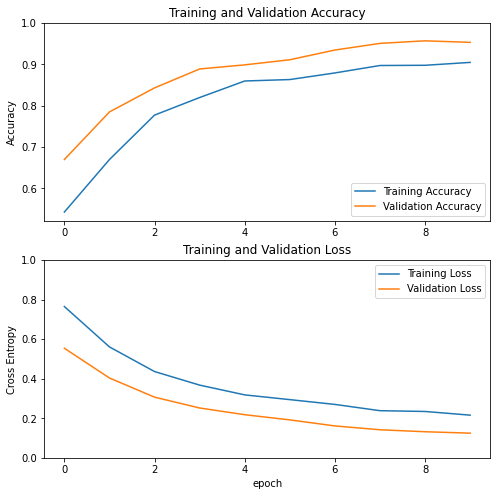

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [28]:
base_model.trainable = True

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [30]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         


 sequential (Sequential)     (None, 160, 160, 3)       0         


 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         


 )                                                               


 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         


 a)                                                              


 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   


 ional)                                                          


 global_average_pooling2d (G  (None, 1280)             0         


 lobalAveragePooling2D)                                          


 dropout (Dropout)           (None, 1280)              0         


 dense (Dense)               (None, 1)                 1281      


Total params: 2,259,265


Trainable params: 1,862,721


Non-trainable params: 396,544


_________________________________________________________________


In [32]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [33]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


 1/63 [..............................] - ETA: 4:34 - loss: 0.2387 - accuracy: 0.9062

 3/63 [>.............................] - ETA: 2s - loss: 0.2282 - accuracy: 0.9375  

 5/63 [=>............................] - ETA: 2s - loss: 0.1860 - accuracy: 0.9375

 7/63 [==>...........................] - ETA: 2s - loss: 0.1670 - accuracy: 0.9420

 9/63 [===>..........................] - ETA: 2s - loss: 0.1691 - accuracy: 0.9340

11/63 [====>.........................] - ETA: 1s - loss: 0.1585 - accuracy: 0.9432

13/63 [=====>........................] - ETA: 1s - loss: 0.1515 - accuracy: 0.9423

15/63 [======>.......................] - ETA: 1s - loss: 0.1612 - accuracy: 0.9396

17/63 [=======>......................] - ETA: 1s - loss: 0.1543 - accuracy: 0.9412

19/63 [========>.....................] - ETA: 1s - loss: 0.1546 - accuracy: 0.9391

21/63 [=========>....................] - ETA: 1s - loss: 0.1669 - accuracy: 0.9315

23/63 [=========>....................] - ETA: 1s - loss: 0.1666 - accuracy: 0.9321

25/63 [==========>...................] - ETA: 1s - loss: 0.1620 - accuracy: 0.9350

27/63 [===========>..................] - ETA: 1s - loss: 0.1607 - accuracy: 0.9340

29/63 [============>.................] - ETA: 1s - loss: 0.1613 - accuracy: 0.9310

31/63 [=============>................] - ETA: 1s - loss: 0.1602 - accuracy: 0.9335

33/63 [==============>...............] - ETA: 1s - loss: 0.1631 - accuracy: 0.9318

35/63 [===============>..............] - ETA: 1s - loss: 0.1623 - accuracy: 0.9304

37/63 [================>.............] - ETA: 0s - loss: 0.1616 - accuracy: 0.9307

39/63 [=================>............] - ETA: 0s - loss: 0.1594 - accuracy: 0.9327

41/63 [==================>...........] - ETA: 0s - loss: 0.1595 - accuracy: 0.9306

43/63 [===================>..........] - ETA: 0s - loss: 0.1615 - accuracy: 0.9295

45/63 [====================>.........] - ETA: 0s - loss: 0.1593 - accuracy: 0.9312

47/63 [=====================>........] - ETA: 0s - loss: 0.1603 - accuracy: 0.9302

49/63 [======================>.......] - ETA: 0s - loss: 0.1599 - accuracy: 0.9292

51/63 [=======================>......] - ETA: 0s - loss: 0.1592 - accuracy: 0.9289

53/63 [========================>.....] - ETA: 0s - loss: 0.1575 - accuracy: 0.9292

55/63 [=========================>....] - ETA: 0s - loss: 0.1552 - accuracy: 0.9295

57/63 [==========================>...] - ETA: 0s - loss: 0.1536 - accuracy: 0.9309

59/63 [===========================>..] - ETA: 0s - loss: 0.1515 - accuracy: 0.9322

61/63 [============================>.] - ETA: 0s - loss: 0.1507 - accuracy: 0.9324

63/63 [==============================] - ETA: 0s - loss: 0.1508 - accuracy: 0.9320

63/63 [==============================] - 8s 56ms/step - loss: 0.1508 - accuracy: 0.9320 - val_loss: 0.0555 - val_accuracy: 0.9814


Epoch 11/20


 1/63 [..............................] - ETA: 4s - loss: 0.0182 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 2s - loss: 0.0413 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 2s - loss: 0.0842 - accuracy: 0.9812

 7/63 [==>...........................] - ETA: 2s - loss: 0.0736 - accuracy: 0.9821

 9/63 [===>..........................] - ETA: 1s - loss: 0.0877 - accuracy: 0.9792

11/63 [====>.........................] - ETA: 1s - loss: 0.1086 - accuracy: 0.9659

13/63 [=====>........................] - ETA: 1s - loss: 0.1049 - accuracy: 0.9663

15/63 [======>.......................] - ETA: 1s - loss: 0.1019 - accuracy: 0.9646

17/63 [=======>......................] - ETA: 1s - loss: 0.1055 - accuracy: 0.9632

19/63 [========>.....................] - ETA: 1s - loss: 0.1162 - accuracy: 0.9589

21/63 [=========>....................] - ETA: 1s - loss: 0.1176 - accuracy: 0.9568

23/63 [=========>....................] - ETA: 1s - loss: 0.1181 - accuracy: 0.9579

25/63 [==========>...................] - ETA: 1s - loss: 0.1210 - accuracy: 0.9563

27/63 [===========>..................] - ETA: 1s - loss: 0.1183 - accuracy: 0.9572

29/63 [============>.................] - ETA: 1s - loss: 0.1167 - accuracy: 0.9569

31/63 [=============>................] - ETA: 1s - loss: 0.1261 - accuracy: 0.9526

33/63 [==============>...............] - ETA: 1s - loss: 0.1248 - accuracy: 0.9527

35/63 [===============>..............] - ETA: 1s - loss: 0.1227 - accuracy: 0.9518

37/63 [================>.............] - ETA: 0s - loss: 0.1223 - accuracy: 0.9519

39/63 [=================>............] - ETA: 0s - loss: 0.1242 - accuracy: 0.9511

41/63 [==================>...........] - ETA: 0s - loss: 0.1231 - accuracy: 0.9520

43/63 [===================>..........] - ETA: 0s - loss: 0.1253 - accuracy: 0.9520

45/63 [====================>.........] - ETA: 0s - loss: 0.1231 - accuracy: 0.9528

47/63 [=====================>........] - ETA: 0s - loss: 0.1276 - accuracy: 0.9508

49/63 [======================>.......] - ETA: 0s - loss: 0.1294 - accuracy: 0.9496

51/63 [=======================>......] - ETA: 0s - loss: 0.1292 - accuracy: 0.9504

53/63 [========================>.....] - ETA: 0s - loss: 0.1279 - accuracy: 0.9505

55/63 [=========================>....] - ETA: 0s - loss: 0.1290 - accuracy: 0.9500

57/63 [==========================>...] - ETA: 0s - loss: 0.1269 - accuracy: 0.9507

59/63 [===========================>..] - ETA: 0s - loss: 0.1248 - accuracy: 0.9513

61/63 [============================>.] - ETA: 0s - loss: 0.1236 - accuracy: 0.9513

63/63 [==============================] - ETA: 0s - loss: 0.1231 - accuracy: 0.9515

63/63 [==============================] - 3s 44ms/step - loss: 0.1231 - accuracy: 0.9515 - val_loss: 0.0437 - val_accuracy: 0.9827


Epoch 12/20


 1/63 [..............................] - ETA: 3s - loss: 0.0985 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 2s - loss: 0.0786 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 2s - loss: 0.0932 - accuracy: 0.9625

 7/63 [==>...........................] - ETA: 2s - loss: 0.0767 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 2s - loss: 0.0929 - accuracy: 0.9618

11/63 [====>.........................] - ETA: 1s - loss: 0.0957 - accuracy: 0.9602

13/63 [=====>........................] - ETA: 1s - loss: 0.0977 - accuracy: 0.9567

15/63 [======>.......................] - ETA: 1s - loss: 0.1036 - accuracy: 0.9521

17/63 [=======>......................] - ETA: 1s - loss: 0.1027 - accuracy: 0.9504

19/63 [========>.....................] - ETA: 1s - loss: 0.1005 - accuracy: 0.9523

21/63 [=========>....................] - ETA: 1s - loss: 0.1071 - accuracy: 0.9494

23/63 [=========>....................] - ETA: 1s - loss: 0.1074 - accuracy: 0.9511

25/63 [==========>...................] - ETA: 1s - loss: 0.1125 - accuracy: 0.9488

27/63 [===========>..................] - ETA: 1s - loss: 0.1088 - accuracy: 0.9502

29/63 [============>.................] - ETA: 1s - loss: 0.1036 - accuracy: 0.9526

31/63 [=============>................] - ETA: 1s - loss: 0.1028 - accuracy: 0.9526

33/63 [==============>...............] - ETA: 1s - loss: 0.1039 - accuracy: 0.9527

35/63 [===============>..............] - ETA: 1s - loss: 0.1039 - accuracy: 0.9527

37/63 [================>.............] - ETA: 0s - loss: 0.1055 - accuracy: 0.9527

39/63 [=================>............] - ETA: 0s - loss: 0.1084 - accuracy: 0.9519

41/63 [==================>...........] - ETA: 0s - loss: 0.1081 - accuracy: 0.9512

43/63 [===================>..........] - ETA: 0s - loss: 0.1074 - accuracy: 0.9513

45/63 [====================>.........] - ETA: 0s - loss: 0.1138 - accuracy: 0.9500

47/63 [=====================>........] - ETA: 0s - loss: 0.1132 - accuracy: 0.9508

49/63 [======================>.......] - ETA: 0s - loss: 0.1104 - accuracy: 0.9528

51/63 [=======================>......] - ETA: 0s - loss: 0.1104 - accuracy: 0.9528

53/63 [========================>.....] - ETA: 0s - loss: 0.1108 - accuracy: 0.9528

55/63 [=========================>....] - ETA: 0s - loss: 0.1097 - accuracy: 0.9528

57/63 [==========================>...] - ETA: 0s - loss: 0.1103 - accuracy: 0.9529

59/63 [===========================>..] - ETA: 0s - loss: 0.1074 - accuracy: 0.9544

61/63 [============================>.] - ETA: 0s - loss: 0.1064 - accuracy: 0.9549

63/63 [==============================] - ETA: 0s - loss: 0.1057 - accuracy: 0.9550

63/63 [==============================] - 3s 44ms/step - loss: 0.1057 - accuracy: 0.9550 - val_loss: 0.0409 - val_accuracy: 0.9851


Epoch 13/20


 1/63 [..............................] - ETA: 3s - loss: 0.0211 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 2s - loss: 0.0759 - accuracy: 0.9896

 5/63 [=>............................] - ETA: 2s - loss: 0.0548 - accuracy: 0.9937

 7/63 [==>...........................] - ETA: 2s - loss: 0.0544 - accuracy: 0.9911

 9/63 [===>..........................] - ETA: 1s - loss: 0.0655 - accuracy: 0.9757

11/63 [====>.........................] - ETA: 1s - loss: 0.0766 - accuracy: 0.9688

13/63 [=====>........................] - ETA: 1s - loss: 0.0946 - accuracy: 0.9639

15/63 [======>.......................] - ETA: 1s - loss: 0.0983 - accuracy: 0.9604

17/63 [=======>......................] - ETA: 1s - loss: 0.0917 - accuracy: 0.9632

19/63 [========>.....................] - ETA: 1s - loss: 0.0874 - accuracy: 0.9671

21/63 [=========>....................] - ETA: 1s - loss: 0.0905 - accuracy: 0.9658

23/63 [=========>....................] - ETA: 1s - loss: 0.1025 - accuracy: 0.9633

25/63 [==========>...................] - ETA: 1s - loss: 0.1041 - accuracy: 0.9625

27/63 [===========>..................] - ETA: 1s - loss: 0.1005 - accuracy: 0.9618

29/63 [============>.................] - ETA: 1s - loss: 0.1018 - accuracy: 0.9612

31/63 [=============>................] - ETA: 1s - loss: 0.0983 - accuracy: 0.9617

33/63 [==============>...............] - ETA: 1s - loss: 0.0957 - accuracy: 0.9631

35/63 [===============>..............] - ETA: 1s - loss: 0.0961 - accuracy: 0.9625

37/63 [================>.............] - ETA: 0s - loss: 0.0959 - accuracy: 0.9620

39/63 [=================>............] - ETA: 0s - loss: 0.1005 - accuracy: 0.9607

41/63 [==================>...........] - ETA: 0s - loss: 0.0998 - accuracy: 0.9611

43/63 [===================>..........] - ETA: 0s - loss: 0.1003 - accuracy: 0.9608

45/63 [====================>.........] - ETA: 0s - loss: 0.0996 - accuracy: 0.9604

47/63 [=====================>........] - ETA: 0s - loss: 0.0972 - accuracy: 0.9614

49/63 [======================>.......] - ETA: 0s - loss: 0.0956 - accuracy: 0.9624

51/63 [=======================>......] - ETA: 0s - loss: 0.0962 - accuracy: 0.9620

53/63 [========================>.....] - ETA: 0s - loss: 0.0960 - accuracy: 0.9623

55/63 [=========================>....] - ETA: 0s - loss: 0.0967 - accuracy: 0.9608

57/63 [==========================>...] - ETA: 0s - loss: 0.0952 - accuracy: 0.9616

59/63 [===========================>..] - ETA: 0s - loss: 0.0938 - accuracy: 0.9624

61/63 [============================>.] - ETA: 0s - loss: 0.0925 - accuracy: 0.9631

63/63 [==============================] - ETA: 0s - loss: 0.0935 - accuracy: 0.9620

63/63 [==============================] - 3s 44ms/step - loss: 0.0935 - accuracy: 0.9620 - val_loss: 0.0361 - val_accuracy: 0.9889


Epoch 14/20


 1/63 [..............................] - ETA: 3s - loss: 0.0125 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 2s - loss: 0.1178 - accuracy: 0.9583

 5/63 [=>............................] - ETA: 2s - loss: 0.0967 - accuracy: 0.9625

 7/63 [==>...........................] - ETA: 2s - loss: 0.0823 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 1s - loss: 0.0713 - accuracy: 0.9757

11/63 [====>.........................] - ETA: 1s - loss: 0.0827 - accuracy: 0.9716

13/63 [=====>........................] - ETA: 1s - loss: 0.0840 - accuracy: 0.9688

15/63 [======>.......................] - ETA: 1s - loss: 0.0947 - accuracy: 0.9667

17/63 [=======>......................] - ETA: 1s - loss: 0.0987 - accuracy: 0.9669

19/63 [========>.....................] - ETA: 1s - loss: 0.1007 - accuracy: 0.9655

21/63 [=========>....................] - ETA: 1s - loss: 0.1050 - accuracy: 0.9628

23/63 [=========>....................] - ETA: 1s - loss: 0.0987 - accuracy: 0.9647

25/63 [==========>...................] - ETA: 1s - loss: 0.0999 - accuracy: 0.9638

27/63 [===========>..................] - ETA: 1s - loss: 0.0978 - accuracy: 0.9641

29/63 [============>.................] - ETA: 1s - loss: 0.0956 - accuracy: 0.9644

31/63 [=============>................] - ETA: 1s - loss: 0.0957 - accuracy: 0.9657

33/63 [==============>...............] - ETA: 1s - loss: 0.0928 - accuracy: 0.9669

35/63 [===============>..............] - ETA: 1s - loss: 0.0950 - accuracy: 0.9643

37/63 [================>.............] - ETA: 0s - loss: 0.0924 - accuracy: 0.9654

39/63 [=================>............] - ETA: 0s - loss: 0.0924 - accuracy: 0.9647

41/63 [==================>...........] - ETA: 0s - loss: 0.0931 - accuracy: 0.9649

43/63 [===================>..........] - ETA: 0s - loss: 0.0959 - accuracy: 0.9637

45/63 [====================>.........] - ETA: 0s - loss: 0.0963 - accuracy: 0.9632

47/63 [=====================>........] - ETA: 0s - loss: 0.0958 - accuracy: 0.9628

49/63 [======================>.......] - ETA: 0s - loss: 0.0958 - accuracy: 0.9630

51/63 [=======================>......] - ETA: 0s - loss: 0.0962 - accuracy: 0.9614

53/63 [========================>.....] - ETA: 0s - loss: 0.0960 - accuracy: 0.9617

55/63 [=========================>....] - ETA: 0s - loss: 0.0971 - accuracy: 0.9619

57/63 [==========================>...] - ETA: 0s - loss: 0.0945 - accuracy: 0.9633

59/63 [===========================>..] - ETA: 0s - loss: 0.0949 - accuracy: 0.9624

61/63 [============================>.] - ETA: 0s - loss: 0.0944 - accuracy: 0.9626

63/63 [==============================] - ETA: 0s - loss: 0.0929 - accuracy: 0.9635

63/63 [==============================] - 3s 44ms/step - loss: 0.0929 - accuracy: 0.9635 - val_loss: 0.0304 - val_accuracy: 0.9901


Epoch 15/20


 1/63 [..............................] - ETA: 3s - loss: 0.0421 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 2s - loss: 0.0749 - accuracy: 0.9792

 5/63 [=>............................] - ETA: 2s - loss: 0.0726 - accuracy: 0.9750

 7/63 [==>...........................] - ETA: 2s - loss: 0.0707 - accuracy: 0.9777

 9/63 [===>..........................] - ETA: 1s - loss: 0.0753 - accuracy: 0.9757

11/63 [====>.........................] - ETA: 1s - loss: 0.0703 - accuracy: 0.9773

13/63 [=====>........................] - ETA: 1s - loss: 0.0667 - accuracy: 0.9784

15/63 [======>.......................] - ETA: 1s - loss: 0.0632 - accuracy: 0.9792

17/63 [=======>......................] - ETA: 1s - loss: 0.0603 - accuracy: 0.9816

19/63 [========>.....................] - ETA: 1s - loss: 0.0687 - accuracy: 0.9786

21/63 [=========>....................] - ETA: 1s - loss: 0.0715 - accuracy: 0.9747

23/63 [=========>....................] - ETA: 1s - loss: 0.0746 - accuracy: 0.9728

25/63 [==========>...................] - ETA: 1s - loss: 0.0730 - accuracy: 0.9725

27/63 [===========>..................] - ETA: 1s - loss: 0.0788 - accuracy: 0.9722

29/63 [============>.................] - ETA: 1s - loss: 0.0878 - accuracy: 0.9677

31/63 [=============>................] - ETA: 1s - loss: 0.0850 - accuracy: 0.9688

33/63 [==============>...............] - ETA: 1s - loss: 0.0860 - accuracy: 0.9669

35/63 [===============>..............] - ETA: 1s - loss: 0.0820 - accuracy: 0.9688

37/63 [================>.............] - ETA: 0s - loss: 0.0808 - accuracy: 0.9688

39/63 [=================>............] - ETA: 0s - loss: 0.0795 - accuracy: 0.9688

41/63 [==================>...........] - ETA: 0s - loss: 0.0787 - accuracy: 0.9688

43/63 [===================>..........] - ETA: 0s - loss: 0.0788 - accuracy: 0.9680

45/63 [====================>.........] - ETA: 0s - loss: 0.0813 - accuracy: 0.9660

47/63 [=====================>........] - ETA: 0s - loss: 0.0799 - accuracy: 0.9668

49/63 [======================>.......] - ETA: 0s - loss: 0.0786 - accuracy: 0.9668

51/63 [=======================>......] - ETA: 0s - loss: 0.0788 - accuracy: 0.9669

53/63 [========================>.....] - ETA: 0s - loss: 0.0784 - accuracy: 0.9676

55/63 [=========================>....] - ETA: 0s - loss: 0.0788 - accuracy: 0.9676

57/63 [==========================>...] - ETA: 0s - loss: 0.0789 - accuracy: 0.9677

59/63 [===========================>..] - ETA: 0s - loss: 0.0795 - accuracy: 0.9677

61/63 [============================>.] - ETA: 0s - loss: 0.0802 - accuracy: 0.9672

63/63 [==============================] - ETA: 0s - loss: 0.0797 - accuracy: 0.9675

63/63 [==============================] - 3s 44ms/step - loss: 0.0797 - accuracy: 0.9675 - val_loss: 0.0309 - val_accuracy: 0.9876


Epoch 16/20


 1/63 [..............................] - ETA: 3s - loss: 0.0161 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 2s - loss: 0.0690 - accuracy: 0.9792

 5/63 [=>............................] - ETA: 2s - loss: 0.0708 - accuracy: 0.9812

 7/63 [==>...........................] - ETA: 2s - loss: 0.0611 - accuracy: 0.9866

 9/63 [===>..........................] - ETA: 1s - loss: 0.0728 - accuracy: 0.9757

11/63 [====>.........................] - ETA: 1s - loss: 0.0925 - accuracy: 0.9659

13/63 [=====>........................] - ETA: 1s - loss: 0.0849 - accuracy: 0.9712

15/63 [======>.......................] - ETA: 1s - loss: 0.0784 - accuracy: 0.9729

17/63 [=======>......................] - ETA: 1s - loss: 0.0818 - accuracy: 0.9724

19/63 [========>.....................] - ETA: 1s - loss: 0.0787 - accuracy: 0.9720

21/63 [=========>....................] - ETA: 1s - loss: 0.0752 - accuracy: 0.9717

23/63 [=========>....................] - ETA: 1s - loss: 0.0823 - accuracy: 0.9701

25/63 [==========>...................] - ETA: 1s - loss: 0.0777 - accuracy: 0.9712

27/63 [===========>..................] - ETA: 1s - loss: 0.0770 - accuracy: 0.9711

29/63 [============>.................] - ETA: 1s - loss: 0.0781 - accuracy: 0.9709

31/63 [=============>................] - ETA: 1s - loss: 0.0836 - accuracy: 0.9677

33/63 [==============>...............] - ETA: 1s - loss: 0.0836 - accuracy: 0.9688

35/63 [===============>..............] - ETA: 1s - loss: 0.0830 - accuracy: 0.9688

37/63 [================>.............] - ETA: 0s - loss: 0.0817 - accuracy: 0.9688

39/63 [=================>............] - ETA: 0s - loss: 0.0824 - accuracy: 0.9679

41/63 [==================>...........] - ETA: 0s - loss: 0.0806 - accuracy: 0.9680

43/63 [===================>..........] - ETA: 0s - loss: 0.0805 - accuracy: 0.9680

45/63 [====================>.........] - ETA: 0s - loss: 0.0806 - accuracy: 0.9674

47/63 [=====================>........] - ETA: 0s - loss: 0.0792 - accuracy: 0.9674

49/63 [======================>.......] - ETA: 0s - loss: 0.0770 - accuracy: 0.9688

51/63 [=======================>......] - ETA: 0s - loss: 0.0802 - accuracy: 0.9675

53/63 [========================>.....] - ETA: 0s - loss: 0.0850 - accuracy: 0.9652

55/63 [=========================>....] - ETA: 0s - loss: 0.0830 - accuracy: 0.9659

57/63 [==========================>...] - ETA: 0s - loss: 0.0843 - accuracy: 0.9649

59/63 [===========================>..] - ETA: 0s - loss: 0.0829 - accuracy: 0.9656

61/63 [============================>.] - ETA: 0s - loss: 0.0821 - accuracy: 0.9662

63/63 [==============================] - ETA: 0s - loss: 0.0809 - accuracy: 0.9670

63/63 [==============================] - 3s 44ms/step - loss: 0.0809 - accuracy: 0.9670 - val_loss: 0.0270 - val_accuracy: 0.9876


Epoch 17/20


 1/63 [..............................] - ETA: 3s - loss: 0.0413 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 2s - loss: 0.0845 - accuracy: 0.9479

 5/63 [=>............................] - ETA: 2s - loss: 0.0694 - accuracy: 0.9625

 7/63 [==>...........................] - ETA: 2s - loss: 0.0872 - accuracy: 0.9554

 9/63 [===>..........................] - ETA: 2s - loss: 0.0724 - accuracy: 0.9653

11/63 [====>.........................] - ETA: 1s - loss: 0.0694 - accuracy: 0.9659

13/63 [=====>........................] - ETA: 1s - loss: 0.0779 - accuracy: 0.9615

15/63 [======>.......................] - ETA: 1s - loss: 0.0825 - accuracy: 0.9625

17/63 [=======>......................] - ETA: 1s - loss: 0.0909 - accuracy: 0.9614

19/63 [========>.....................] - ETA: 1s - loss: 0.0885 - accuracy: 0.9638

21/63 [=========>....................] - ETA: 1s - loss: 0.0870 - accuracy: 0.9658

23/63 [=========>....................] - ETA: 1s - loss: 0.0808 - accuracy: 0.9688

25/63 [==========>...................] - ETA: 1s - loss: 0.0806 - accuracy: 0.9688

27/63 [===========>..................] - ETA: 1s - loss: 0.0758 - accuracy: 0.9711

29/63 [============>.................] - ETA: 1s - loss: 0.0872 - accuracy: 0.9634

31/63 [=============>................] - ETA: 1s - loss: 0.0865 - accuracy: 0.9637

33/63 [==============>...............] - ETA: 1s - loss: 0.0838 - accuracy: 0.9650

35/63 [===============>..............] - ETA: 1s - loss: 0.0840 - accuracy: 0.9643

37/63 [================>.............] - ETA: 0s - loss: 0.0832 - accuracy: 0.9645

39/63 [=================>............] - ETA: 0s - loss: 0.0855 - accuracy: 0.9639

41/63 [==================>...........] - ETA: 0s - loss: 0.0824 - accuracy: 0.9657

43/63 [===================>..........] - ETA: 0s - loss: 0.0824 - accuracy: 0.9658

45/63 [====================>.........] - ETA: 0s - loss: 0.0797 - accuracy: 0.9674

47/63 [=====================>........] - ETA: 0s - loss: 0.0808 - accuracy: 0.9674

49/63 [======================>.......] - ETA: 0s - loss: 0.0783 - accuracy: 0.9688

51/63 [=======================>......] - ETA: 0s - loss: 0.0788 - accuracy: 0.9688

53/63 [========================>.....] - ETA: 0s - loss: 0.0786 - accuracy: 0.9676

55/63 [=========================>....] - ETA: 0s - loss: 0.0804 - accuracy: 0.9665

57/63 [==========================>...] - ETA: 0s - loss: 0.0788 - accuracy: 0.9671

59/63 [===========================>..] - ETA: 0s - loss: 0.0780 - accuracy: 0.9672

61/63 [============================>.] - ETA: 0s - loss: 0.0773 - accuracy: 0.9677

63/63 [==============================] - ETA: 0s - loss: 0.0776 - accuracy: 0.9680

63/63 [==============================] - 3s 44ms/step - loss: 0.0776 - accuracy: 0.9680 - val_loss: 0.0279 - val_accuracy: 0.9864


Epoch 18/20


 1/63 [..............................] - ETA: 3s - loss: 0.0141 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 2s - loss: 0.0772 - accuracy: 0.9792

 5/63 [=>............................] - ETA: 2s - loss: 0.0698 - accuracy: 0.9812

 7/63 [==>...........................] - ETA: 2s - loss: 0.0621 - accuracy: 0.9821

 9/63 [===>..........................] - ETA: 2s - loss: 0.0577 - accuracy: 0.9792

11/63 [====>.........................] - ETA: 1s - loss: 0.0533 - accuracy: 0.9801

13/63 [=====>........................] - ETA: 1s - loss: 0.0530 - accuracy: 0.9808

15/63 [======>.......................] - ETA: 1s - loss: 0.0478 - accuracy: 0.9833

17/63 [=======>......................] - ETA: 1s - loss: 0.0493 - accuracy: 0.9798

19/63 [========>.....................] - ETA: 1s - loss: 0.0512 - accuracy: 0.9786

21/63 [=========>....................] - ETA: 1s - loss: 0.0475 - accuracy: 0.9807

23/63 [=========>....................] - ETA: 1s - loss: 0.0455 - accuracy: 0.9810

25/63 [==========>...................] - ETA: 1s - loss: 0.0434 - accuracy: 0.9825

27/63 [===========>..................] - ETA: 1s - loss: 0.0526 - accuracy: 0.9780

29/63 [============>.................] - ETA: 1s - loss: 0.0608 - accuracy: 0.9741

31/63 [=============>................] - ETA: 1s - loss: 0.0623 - accuracy: 0.9728

33/63 [==============>...............] - ETA: 1s - loss: 0.0613 - accuracy: 0.9735

35/63 [===============>..............] - ETA: 1s - loss: 0.0651 - accuracy: 0.9723

37/63 [================>.............] - ETA: 0s - loss: 0.0661 - accuracy: 0.9721

39/63 [=================>............] - ETA: 0s - loss: 0.0668 - accuracy: 0.9720

41/63 [==================>...........] - ETA: 0s - loss: 0.0658 - accuracy: 0.9726

43/63 [===================>..........] - ETA: 0s - loss: 0.0648 - accuracy: 0.9731

45/63 [====================>.........] - ETA: 0s - loss: 0.0658 - accuracy: 0.9715

47/63 [=====================>........] - ETA: 0s - loss: 0.0639 - accuracy: 0.9727

49/63 [======================>.......] - ETA: 0s - loss: 0.0636 - accuracy: 0.9726

51/63 [=======================>......] - ETA: 0s - loss: 0.0625 - accuracy: 0.9730

53/63 [========================>.....] - ETA: 0s - loss: 0.0627 - accuracy: 0.9735

55/63 [=========================>....] - ETA: 0s - loss: 0.0646 - accuracy: 0.9733

57/63 [==========================>...] - ETA: 0s - loss: 0.0640 - accuracy: 0.9731

59/63 [===========================>..] - ETA: 0s - loss: 0.0636 - accuracy: 0.9735

61/63 [============================>.] - ETA: 0s - loss: 0.0656 - accuracy: 0.9723

63/63 [==============================] - ETA: 0s - loss: 0.0646 - accuracy: 0.9730

63/63 [==============================] - 3s 44ms/step - loss: 0.0646 - accuracy: 0.9730 - val_loss: 0.0244 - val_accuracy: 0.9913


Epoch 19/20


 1/63 [..............................] - ETA: 3s - loss: 0.0136 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 2s - loss: 0.0261 - accuracy: 0.9896

 5/63 [=>............................] - ETA: 2s - loss: 0.0375 - accuracy: 0.9750

 7/63 [==>...........................] - ETA: 2s - loss: 0.0393 - accuracy: 0.9777

 9/63 [===>..........................] - ETA: 2s - loss: 0.0380 - accuracy: 0.9792

11/63 [====>.........................] - ETA: 1s - loss: 0.0402 - accuracy: 0.9801

13/63 [=====>........................] - ETA: 1s - loss: 0.0367 - accuracy: 0.9808

15/63 [======>.......................] - ETA: 1s - loss: 0.0356 - accuracy: 0.9792

17/63 [=======>......................] - ETA: 1s - loss: 0.0350 - accuracy: 0.9816

19/63 [========>.....................] - ETA: 1s - loss: 0.0373 - accuracy: 0.9803

21/63 [=========>....................] - ETA: 1s - loss: 0.0427 - accuracy: 0.9777

23/63 [=========>....................] - ETA: 1s - loss: 0.0504 - accuracy: 0.9755

25/63 [==========>...................] - ETA: 1s - loss: 0.0487 - accuracy: 0.9775

27/63 [===========>..................] - ETA: 1s - loss: 0.0515 - accuracy: 0.9769

29/63 [============>.................] - ETA: 1s - loss: 0.0500 - accuracy: 0.9774

31/63 [=============>................] - ETA: 1s - loss: 0.0508 - accuracy: 0.9768

33/63 [==============>...............] - ETA: 1s - loss: 0.0508 - accuracy: 0.9773

35/63 [===============>..............] - ETA: 1s - loss: 0.0514 - accuracy: 0.9777

37/63 [================>.............] - ETA: 0s - loss: 0.0528 - accuracy: 0.9772

39/63 [=================>............] - ETA: 0s - loss: 0.0519 - accuracy: 0.9784

41/63 [==================>...........] - ETA: 0s - loss: 0.0513 - accuracy: 0.9779

43/63 [===================>..........] - ETA: 0s - loss: 0.0537 - accuracy: 0.9767

45/63 [====================>.........] - ETA: 0s - loss: 0.0562 - accuracy: 0.9757

47/63 [=====================>........] - ETA: 0s - loss: 0.0547 - accuracy: 0.9767

49/63 [======================>.......] - ETA: 0s - loss: 0.0559 - accuracy: 0.9764

51/63 [=======================>......] - ETA: 0s - loss: 0.0553 - accuracy: 0.9767

53/63 [========================>.....] - ETA: 0s - loss: 0.0539 - accuracy: 0.9776

55/63 [=========================>....] - ETA: 0s - loss: 0.0535 - accuracy: 0.9784

57/63 [==========================>...] - ETA: 0s - loss: 0.0553 - accuracy: 0.9770

59/63 [===========================>..] - ETA: 0s - loss: 0.0574 - accuracy: 0.9762

61/63 [============================>.] - ETA: 0s - loss: 0.0586 - accuracy: 0.9754

63/63 [==============================] - ETA: 0s - loss: 0.0580 - accuracy: 0.9755

63/63 [==============================] - 3s 44ms/step - loss: 0.0580 - accuracy: 0.9755 - val_loss: 0.0326 - val_accuracy: 0.9901


Epoch 20/20


 1/63 [..............................] - ETA: 3s - loss: 0.0135 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 2s - loss: 0.0314 - accuracy: 0.9792

 5/63 [=>............................] - ETA: 2s - loss: 0.0303 - accuracy: 0.9875

 7/63 [==>...........................] - ETA: 2s - loss: 0.0339 - accuracy: 0.9866

 9/63 [===>..........................] - ETA: 2s - loss: 0.0410 - accuracy: 0.9861

11/63 [====>.........................] - ETA: 1s - loss: 0.0473 - accuracy: 0.9858

13/63 [=====>........................] - ETA: 1s - loss: 0.0415 - accuracy: 0.9880

15/63 [======>.......................] - ETA: 1s - loss: 0.0397 - accuracy: 0.9896

17/63 [=======>......................] - ETA: 1s - loss: 0.0454 - accuracy: 0.9871

19/63 [========>.....................] - ETA: 1s - loss: 0.0479 - accuracy: 0.9852

21/63 [=========>....................] - ETA: 1s - loss: 0.0508 - accuracy: 0.9851

23/63 [=========>....................] - ETA: 1s - loss: 0.0550 - accuracy: 0.9823

25/63 [==========>...................] - ETA: 1s - loss: 0.0531 - accuracy: 0.9825

27/63 [===========>..................] - ETA: 1s - loss: 0.0530 - accuracy: 0.9826

29/63 [============>.................] - ETA: 1s - loss: 0.0522 - accuracy: 0.9838

31/63 [=============>................] - ETA: 1s - loss: 0.0538 - accuracy: 0.9829

33/63 [==============>...............] - ETA: 1s - loss: 0.0521 - accuracy: 0.9830

35/63 [===============>..............] - ETA: 1s - loss: 0.0515 - accuracy: 0.9839

37/63 [================>.............] - ETA: 0s - loss: 0.0526 - accuracy: 0.9831

39/63 [=================>............] - ETA: 0s - loss: 0.0520 - accuracy: 0.9840

41/63 [==================>...........] - ETA: 0s - loss: 0.0502 - accuracy: 0.9848

43/63 [===================>..........] - ETA: 0s - loss: 0.0495 - accuracy: 0.9847

45/63 [====================>.........] - ETA: 0s - loss: 0.0501 - accuracy: 0.9847

47/63 [=====================>........] - ETA: 0s - loss: 0.0505 - accuracy: 0.9840

49/63 [======================>.......] - ETA: 0s - loss: 0.0514 - accuracy: 0.9841

51/63 [=======================>......] - ETA: 0s - loss: 0.0516 - accuracy: 0.9841

53/63 [========================>.....] - ETA: 0s - loss: 0.0503 - accuracy: 0.9841

55/63 [=========================>....] - ETA: 0s - loss: 0.0497 - accuracy: 0.9835

57/63 [==========================>...] - ETA: 0s - loss: 0.0512 - accuracy: 0.9830

59/63 [===========================>..] - ETA: 0s - loss: 0.0522 - accuracy: 0.9825

61/63 [============================>.] - ETA: 0s - loss: 0.0520 - accuracy: 0.9821

63/63 [==============================] - ETA: 0s - loss: 0.0522 - accuracy: 0.9815

63/63 [==============================] - 3s 44ms/step - loss: 0.0522 - accuracy: 0.9815 - val_loss: 0.0248 - val_accuracy: 0.9901


Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

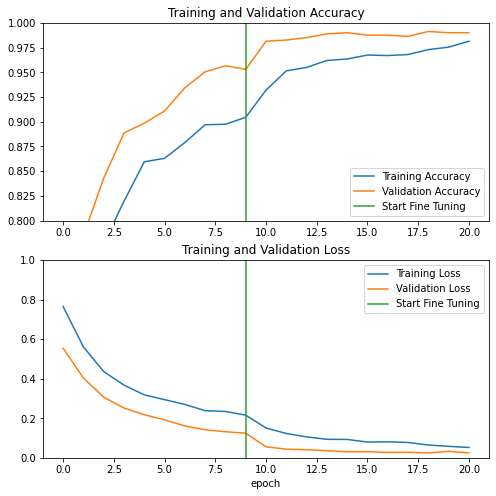

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [36]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/6 [====>.........................] - ETA: 0s - loss: 0.0159 - accuracy: 1.0000

4/6 [===================>..........] - ETA: 0s - loss: 0.0499 - accuracy: 0.9766

6/6 [==============================] - 0s 18ms/step - loss: 0.0383 - accuracy: 0.9844


Test accuracy : 0.984375


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [1 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0]
Labels:
 [1 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0]


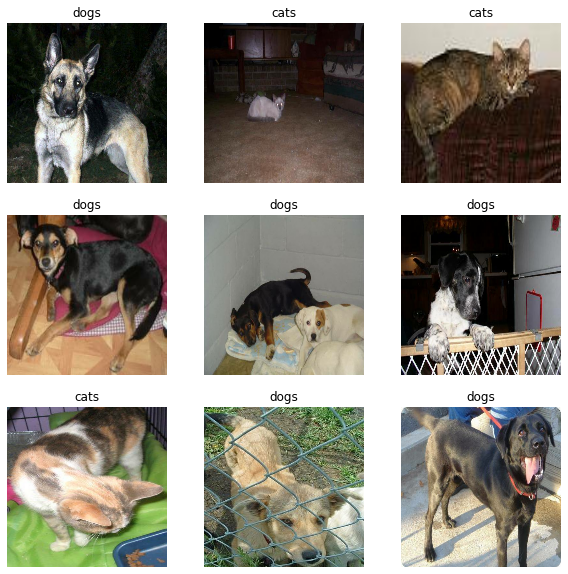

In [37]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
